# Objective
# Create an intelligent cash management system (eg, in ATM) based on cash demand forecasting; predict cash demand
# Overcome unpredictability across ATMs (paydays, holidays)

# Outcome
# Build forecasting models that will be accurate to the tune of  70% on average tell me code

# PREPROCESSING

In [1]:
import pandas as pd
# Load the dataset (assuming ATM transaction data with a 'date' and 'withdrawal_amount' column)
data = pd.read_csv('Cash_withdrawals.csv')
data.head()

,Date,Withdrawal_Amount
0,1/1/2022,12639.731070
1,1/2/2022,9463.829318
2,1/3/2022,3467.537929
3,1/4/2022,3015.699487
4,1/5/2022,9353.366534


In [2]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               7300 non-null   object 
 1   Withdrawal_Amount  7300 non-null   float64
dtypes: float64(1), object(1)
memory usage: 114.2+ KB


In [3]:
data.describe() 

,Withdrawal_Amount
count,7300.000000
mean,6664.269183
std,2832.709735
min,1546.834272
25%,4400.405948
50%,6513.387645
75%,8647.439395
max,18186.492730


In [4]:

# Convert date to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['day_of_week'] = data['Date'].dt.dayofweek
data['month'] = data['Date'].dt.month
data['day_of_month'] = data['Date'].dt.day
data['year'] = data['Date'].dt.year
data['Is_Weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['Is_Payday'] = data['day_of_month'].apply(lambda x: 1 if x in [1, 15, 30] else 0)  # Example payday logic


In [5]:
data.head()


,Date,Withdrawal_Amount,day_of_week,month,day_of_month,year,Is_Weekend,Is_Payday
0,2022-01-01,12639.731070,5,1,1,2022,1,1
1,2022-01-02,9463.829318,6,1,2,2022,1,0
2,2022-01-03,3467.537929,0,1,3,2022,0,0
3,2022-01-04,3015.699487,1,1,4,2022,0,0
4,2022-01-05,9353.366534,2,1,5,2022,0,0


In [6]:
# Create lag features to predict based on past withdrawals
for lag in range(1, 8):  # Past 7 days as features
    data[f'lag_{lag}'] = data['Withdrawal_Amount'].shift(lag)

In [7]:
data.head()

,Date,Withdrawal_Amount,day_of_week,month,day_of_month,year,Is_Weekend,Is_Payday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,2022-01-01,12639.731070,5,1,1,2022,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-02,9463.829318,6,1,2,2022,1,0,12639.731070,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-03,3467.537929,0,1,3,2022,0,0,9463.829318,12639.731070,NaN,NaN,NaN,NaN,NaN
3,2022-01-04,3015.699487,1,1,4,2022,0,0,3467.537929,9463.829318,12639.731070,NaN,NaN,NaN,NaN
4,2022-01-05,9353.366534,2,1,5,2022,0,0,3015.699487,3467.537929,9463.829318,12639.73107,NaN,NaN,NaN


In [8]:
# Drop missing values created by lag features
data.dropna(inplace=True)

In [9]:
data.head()

,Date,Withdrawal_Amount,day_of_week,month,day_of_month,year,Is_Weekend,Is_Payday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,2022-01-08,4691.355288,5,1,8,2022,1,0,1837.695240,6758.921820,9353.366534,3015.699487,3467.537929,9463.829318,12639.731070
8,2022-01-09,2721.645063,6,1,9,2022,1,0,4691.355288,1837.695240,6758.921820,9353.366534,3015.699487,3467.537929,9463.829318
9,2022-01-10,8014.884438,0,1,10,2022,0,0,2721.645063,4691.355288,1837.695240,6758.921820,9353.366534,3015.699487,3467.537929
10,2022-01-11,6383.519821,1,1,11,2022,0,0,8014.884438,2721.645063,4691.355288,1837.695240,6758.921820,9353.366534,3015.699487
11,2022-01-12,5768.265684,2,1,12,2022,0,0,6383.519821,8014.884438,2721.645063,4691.355288,1837.695240,6758.921820,9353.366534


# XGBoost model

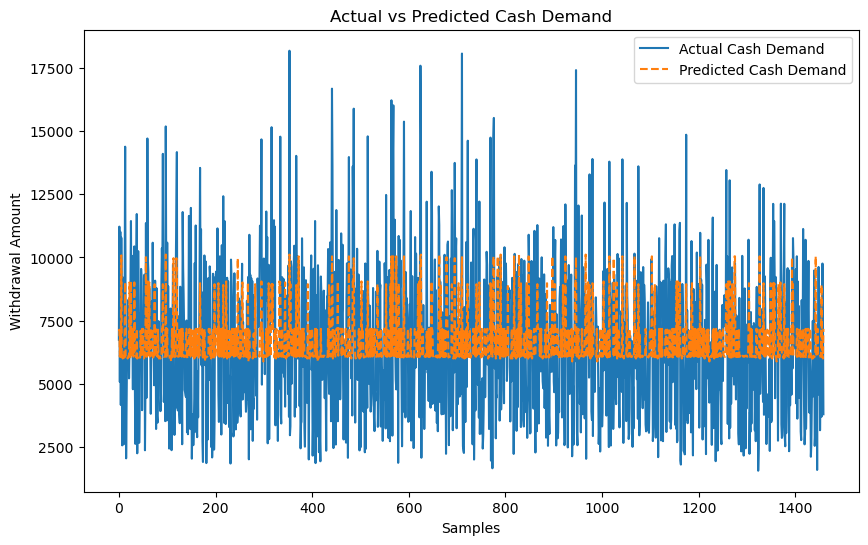

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Define the target variable and features
X = data[['day_of_week', 'month', 'day_of_month', 'year', 'Is_Weekend', 'Is_Payday'] + [f'lag_{lag}' for lag in range(1, 8)]]
y = data['Withdrawal_Amount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=1, random_state=42)
model.fit(X_train, y_train)
                         

# Make predictions
y_pred = model.predict(X_test)

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Cash Demand')
plt.plot(y_pred, label='Predicted Cash Demand', linestyle='dashed')
plt.title('Actual vs Predicted Cash Demand')
plt.xlabel('Samples')
plt.ylabel('Withdrawal Amount')
plt.legend()
plt.show()


In [12]:
print(y_pred)

[7100.141  7140.6733 6071.2627 ... 6110.002  5998.2407 7173.163 ]


# Evaluate the model

In [13]:

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

# Calculate accuracy based on 70% benchmark
accuracy = (1 - mae / np.mean(y_test)) * 100
print(f'Accuracy: {accuracy:.2f}%')


Mean Absolute Error (MAE): 2239.021252898775
Mean Squared Error (MSE): 6889036.012587571
Accuracy: 66.43%
